In [3]:
# Imports etc
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
from torchvision.io import read_video

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [4]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16
dia = 10
mask_threshold = 0.3

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape

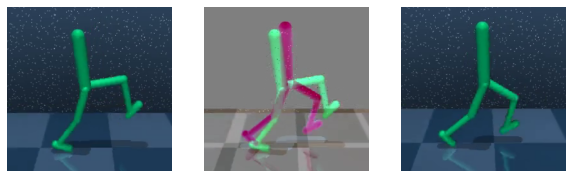

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img_tensor[0, 0].permute(1, 2, 0))
ax[0].axis('off')
ax[1].imshow((img_tensor[0, 0] - img_tensor[0, -1] + 0.5).clip(0.0, 1.0).permute(1, 2, 0))
ax[1].axis('off')
ax[2].imshow(img_tensor[0, -1].permute(1, 2, 0))
ax[2].axis('off')
plt.show()

# Perfect Key-Points

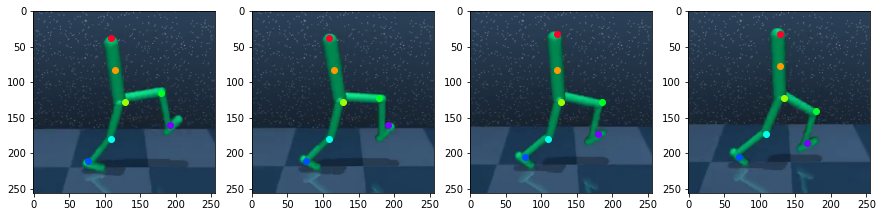

In [6]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

cm = pylab.get_cmap('gist_rainbow')
perfect_kpts = kpts_2_img_coordinates(perfect_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(perfect_kpts[0, t, k, 0], perfect_kpts[0, t, k, 1], color=cm(1.*k/K))
plt.show()

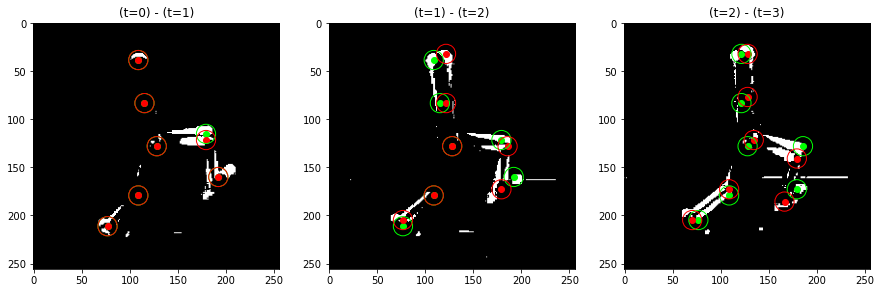

In [7]:
from torch.nn.functional import threshold

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for t in range(1, T):
    # plt.imshow((d + 0.5).clip(0.0, 1.0).permute(1, 2, 0))
    d = img_tensor[0, t-1] - img_tensor[0, t]
    # Filter frame differences to distinguish between background and foreground
    d_mask = torch.where((torch.abs(torch.norm(d, dim=0, p=2)) > mask_threshold), 1.0, 0.0)
    ax[t-1].imshow(d_mask, cmap='gray')
    ax[t-1].set_title(f"(t={t-1}) - (t={t})")
    ax[t-1].scatter(perfect_kpts[0, t-1, :, 0], perfect_kpts[0, t-1, :, 1], color="lime")
    for k in range(perfect_kpts.shape[2]):
        circle1 = plt.Circle((perfect_kpts[0, t-1, k, 0], perfect_kpts[0, t-1, k, 1]), dia, color='lime', fill=False)
        ax[t-1].add_patch(circle1)
        circle1 = plt.Circle((perfect_kpts[0, t, k, 0], perfect_kpts[0, t, k, 1]), dia, color='red', fill=False)
        ax[t-1].add_patch(circle1)
    ax[t-1].scatter(perfect_kpts[0, t, :, 0], perfect_kpts[0, t, :, 1], color="red")
plt.show()

In [8]:
# Counting the number of changed pixels in the regions around key-points
perfect_count = torch.zeros((N, T-1, K, 2))
for n in range(N):
    for t in range(0, T-1):
        d = img_tensor[0, t] - img_tensor[0, t+1]
        # Filter frame differences to distinguish between background and foreground
        d_mask = torch.where((torch.abs(torch.norm(d, dim=0, p=2)) > mask_threshold), 1.0, 0.0)
        for k in range(K):
            kpt_w_1, kpt_h_1 = perfect_kpts[0, t, k, 0], perfect_kpts[0, t, k, 1]
            w_min_1, w_max_1 = max(0, int(kpt_w_1 - 0.5*dia)), min(W-1, int(kpt_w_1 + 0.5*dia))
            h_min_1, h_max_1 = max(0, int(kpt_h_1 - 0.5*dia)), min(H-1, int(kpt_h_1 + 0.5*dia))
            perfect_count[n, t, k, 0] += torch.sum(d_mask[h_min_1:h_max_1, w_min_1:w_max_1])
            
            kpt_w_2, kpt_h_2 = perfect_kpts[0, t+1, k, 0], perfect_kpts[0, t+1, k, 1]
            w_min_2, w_max_2 = max(0, int(kpt_w_2 - 0.5*dia)), min(W-1, int(kpt_w_2 + 0.5*dia))
            h_min_2, h_max_2 = max(0, int(kpt_h_2 - 0.5*dia)), min(H-1, int(kpt_h_2 + 0.5*dia))
            perfect_count[n, t, k, 1] += torch.sum(d_mask[h_min_2:h_max_2, w_min_2:w_max_2])

In [9]:
import numpy as np
# Normalize by radius
normalized_perfect_count = perfect_count / (dia*dia) 
# Normalize by key-points (twice)
normalized_perfect_count = torch.sum(normalized_perfect_count, dim=[-2, -1])/(2 * K)
# Average across batch and time-steps
print(torch.mean(normalized_perfect_count))

tensor(0.2698)


# Worse Key-Points

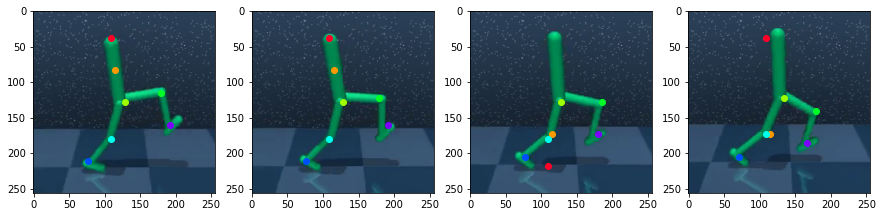

In [10]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))

cm = pylab.get_cmap('gist_rainbow')
bad_kpts = kpts_2_img_coordinates(bad_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(bad_kpts[0, t, k, 0], bad_kpts[0, t, k, 1], color=cm(1.*k/K))
plt.show()

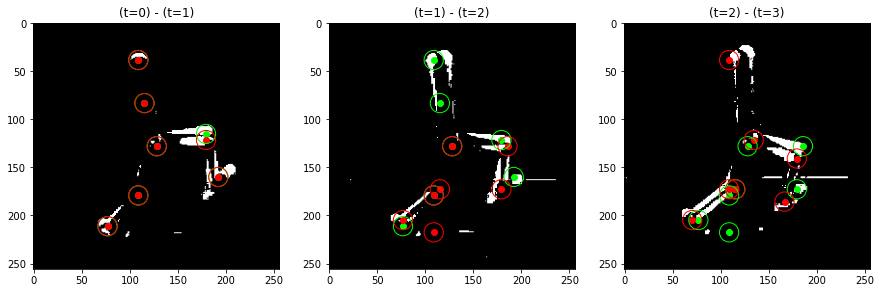

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for t in range(1, T):
    # plt.imshow((d + 0.5).clip(0.0, 1.0).permute(1, 2, 0))
    d = img_tensor[0, t-1] - img_tensor[0, t]
    # Filter frame differences to distinguish between background and foreground
    d_mask = torch.where((torch.abs(torch.norm(d, dim=0, p=2)) > mask_threshold), 1.0, 0.0)
    ax[t-1].imshow(d_mask, cmap='gray')
    ax[t-1].set_title(f"(t={t-1}) - (t={t})")
    ax[t-1].scatter(bad_kpts[0, t-1, :, 0], bad_kpts[0, t-1, :, 1], color="lime")
    for k in range(bad_kpts.shape[2]):
        circle1 = plt.Circle((bad_kpts[0, t-1, k, 0], bad_kpts[0, t-1, k, 1]), dia, color='lime', fill=False)
        ax[t-1].add_patch(circle1)
        circle1 = plt.Circle((bad_kpts[0, t, k, 0], bad_kpts[0, t, k, 1]), dia, color='red', fill=False)
        ax[t-1].add_patch(circle1)
    ax[t-1].scatter(bad_kpts[0, t, :, 0], bad_kpts[0, t, :, 1], color="red")
plt.show()

In [12]:
# Counting the number of changed pixels in the regions around key-points
bad_count = torch.zeros((N, T-1, K, 2))
for n in range(N):
    for t in range(0, T-1):
        d = img_tensor[0, t] - img_tensor[0, t+1]
        # Filter frame differences to distinguish between background and foreground
        d_mask = torch.where((torch.abs(torch.norm(d, dim=0, p=2)) > mask_threshold), 1.0, 0.0)
        for k in range(K):
            kpt_w_1, kpt_h_1 = bad_kpts[0, t, k, 0], bad_kpts[0, t, k, 1]
            w_min_1, w_max_1 = max(0, int(kpt_w_1 - 0.5*dia)), min(W-1, int(kpt_w_1 + 0.5*dia))
            h_min_1, h_max_1 = max(0, int(kpt_h_1 - 0.5*dia)), min(H-1, int(kpt_h_1 + 0.5*dia))
            bad_count[n, t, k, 0] += torch.sum(d_mask[h_min_1:h_max_1, w_min_1:w_max_1])
            
            kpt_w_2, kpt_h_2 = bad_kpts[0, t+1, k, 0], bad_kpts[0, t+1, k, 1]
            w_min_2, w_max_2 = max(0, int(kpt_w_2 - 0.5*dia)), min(W-1, int(kpt_w_2 + 0.5*dia))
            h_min_2, h_max_2 = max(0, int(kpt_h_2 - 0.5*dia)), min(H-1, int(kpt_h_2 + 0.5*dia))
            bad_count[n, t, k, 1] += torch.sum(d_mask[h_min_2:h_max_2, w_min_2:w_max_2])

In [13]:
# Normalize by radius
normalized_bad_count = bad_count / (dia*dia) 
# Normalize by key-points (twice)
normalized_bad_count = torch.sum(normalized_bad_count, dim=[-2, -1])/(2 * K)
# Average across batch and time-steps
print(torch.mean(normalized_bad_count))

tensor(0.2293)


# Random Key-Points

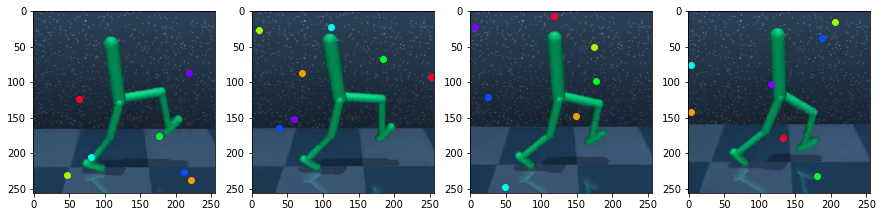

In [14]:
random_kpt_coordinates = get_random_keypoints(T=sample_size).unsqueeze(0)
random_kpt_coordinates = random_kpt_coordinates.repeat((batch_size, 1, 1, 1))

cm = pylab.get_cmap('gist_rainbow')
random_kpts = kpts_2_img_coordinates(random_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(random_kpts[0, t, k, 0], random_kpts[0, t, k, 1], color=cm(1.*k/K))
plt.show()

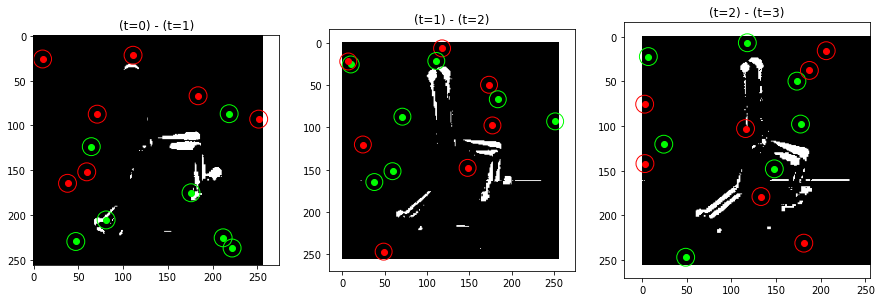

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for t in range(1, T):
    # plt.imshow((d + 0.5).clip(0.0, 1.0).permute(1, 2, 0))
    d = img_tensor[0, t-1] - img_tensor[0, t]
    # Filter frame differences to distinguish between background and foreground
    d_mask = torch.where((torch.abs(torch.norm(d, dim=0, p=2)) > mask_threshold), 1.0, 0.0)
    ax[t-1].imshow(d_mask, cmap='gray')
    ax[t-1].set_title(f"(t={t-1}) - (t={t})")
    ax[t-1].scatter(random_kpts[0, t-1, :, 0], random_kpts[0, t-1, :, 1], color="lime")
    for k in range(random_kpts.shape[2]):
        circle1 = plt.Circle((random_kpts[0, t-1, k, 0], random_kpts[0, t-1, k, 1]), dia, color='lime', fill=False)
        ax[t-1].add_patch(circle1)
        circle1 = plt.Circle((random_kpts[0, t, k, 0], random_kpts[0, t, k, 1]), dia, color='red', fill=False)
        ax[t-1].add_patch(circle1)
    ax[t-1].scatter(random_kpts[0, t, :, 0], random_kpts[0, t, :, 1], color="red")
plt.show()

In [16]:
# Counting the number of changed pixels in the regions around key-points
random_count = torch.zeros((N, T-1, K, 2))
for n in range(1):
    for t in range(0, T-1):
        d = img_tensor[0, t] - img_tensor[0, t+1]
        # Filter frame differences to distinguish between background and foreground
        d_mask = torch.where((torch.abs(torch.norm(d, dim=0, p=2)) > mask_threshold), 1.0, 0.0)
        for k in range(K):
            kpt_w_1, kpt_h_1 = random_kpts[0, t, k, 0], random_kpts[0, t, k, 1]
            w_min_1, w_max_1 = max(0, int(kpt_w_1 - 0.5*dia)), min(W-1, int(kpt_w_1 + 0.5*dia))
            h_min_1, h_max_1 = max(0, int(kpt_h_1 - 0.5*dia)), min(H-1, int(kpt_h_1 + 0.5*dia))
            random_count[n, t, k, 0] += torch.sum(d_mask[h_min_1:h_max_1, w_min_1:w_max_1])
            
            kpt_w_2, kpt_h_2 = random_kpts[0, t+1, k, 0], random_kpts[0, t+1, k, 1]
            w_min_2, w_max_2 = max(0, int(kpt_w_2 - 0.5*dia)), min(W-1, int(kpt_w_2 + 0.5*dia))
            h_min_2, h_max_2 = max(0, int(kpt_h_2 - 0.5*dia)), min(H-1, int(kpt_h_2 + 0.5*dia))
            random_count[n, t, k, 1] += torch.sum(d_mask[h_min_2:h_max_2, w_min_2:w_max_2])

In [17]:
# Normalize by radius
normalized_random_count = random_count / (dia*dia) 
# Normalize by key-points (twice)
normalized_random_count = torch.sum(normalized_random_count, dim=[-2, -1])/(2 * K)
# Average across batch and time-steps
print(torch.mean(normalized_random_count))

tensor(0.0010)
